## CS336 - Lec5: Transformer语言模型实现

### 目标
实现一个极小的Transformer语言模型（3层，128隐藏维度），包含完整的训练和推理功能。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## 1. 数据准备

In [2]:
# 创建一个简单的文本数据集用于训练
# 使用字符级tokenization

text = """
The quick brown fox jumps over the lazy dog.
Machine learning is a subset of artificial intelligence.
Deep learning uses neural networks with multiple layers.
Transformers have revolutionized natural language processing.
Attention mechanisms allow models to focus on relevant parts of the input.
Language models can generate coherent text by predicting the next token.
The transformer architecture was introduced in the paper "Attention is All You Need".
Self-attention allows each position to attend to all positions in the sequence.
Positional encoding helps the model understand the order of tokens.
Multi-head attention allows the model to attend to information from different representation subspaces.
Feed-forward networks apply point-wise transformations to each position independently.
Layer normalization stabilizes training and improves convergence.
Residual connections help with gradient flow in deep networks.
Pre-norm architecture places layer normalization before the sub-layer.
The model learns to predict the next token in a sequence.
Training involves minimizing the cross-entropy loss over the vocabulary.
Gradient descent updates model parameters to reduce the loss.
Backpropagation computes gradients through the computational graph.
Optimizers like AdamW adaptively adjust learning rates for each parameter.
Learning rate scheduling can improve training stability and convergence.
"""

# 创建字符级词汇表
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"词汇表大小: {vocab_size}")
print(f"字符: {''.join(chars[:50])}...")

# 创建字符到索引的映射
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

def encode(text):
    """将文本编码为token索引"""
    return [char_to_idx[ch] for ch in text]

def decode(indices):
    """将token索引解码为文本"""
    return ''.join([idx_to_char[idx] for idx in indices])

# 编码整个文本
data = torch.tensor(encode(text), dtype=torch.long)
print(f"数据长度: {len(data)}")

词汇表大小: 46
字符: 
 "-.ABDFGLMNOPRSTWYabcdefghijklmnopqrstuvwxyz...
数据长度: 1404


In [3]:
# 创建数据集类
class TextDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size
    
    def __len__(self):
        return len(self.data) - self.block_size
    
    def __getitem__(self, idx):
        # 返回一个序列块：输入和 targets（下一个token）
        x = self.data[idx:idx + self.block_size]
        y = self.data[idx + 1:idx + self.block_size + 1]
        return x, y

# 设置超参数
block_size = 64  # 序列长度
batch_size = 32

# 创建数据集和数据加载器
dataset = TextDataset(data, block_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 测试数据加载器
x, y = next(iter(dataloader))
print(f"输入形状: {x.shape}, 目标形状: {y.shape}")
print(f"输入示例: {decode(x[0].tolist())}")
print(f"目标示例: {decode(y[0].tolist())}")

输入形状: torch.Size([32, 64]), 目标形状: torch.Size([32, 64])
输入示例: achine learning is a subset of artificial intelligence.
Deep lea
目标示例: chine learning is a subset of artificial intelligence.
Deep lear


## 2. 模型实现

### 2.1 Multi-Head Attention

In [4]:
class MultiHeadAttention(nn.Module):
    """多头自注意力机制"""
    
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model必须能被n_heads整除"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # 每个头的维度
        
        # Q, K, V投影层
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        x: (batch_size, seq_len, d_model)
        mask: (batch_size, seq_len, seq_len) 或 None
        返回: (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        
        # 计算Q, K, V
        Q = self.W_q(x)  # (batch_size, seq_len, d_model)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # 重塑为多头形式: (batch_size, seq_len, n_heads, d_k)
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_k)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)  # (batch_size, n_heads, seq_len, seq_len)
        
        # 应用causal mask（如果提供）
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        # Softmax
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # 应用注意力权重到V
        attn_output = torch.matmul(attn_weights, V)  # (batch_size, n_heads, seq_len, d_k)
        
        # 拼接多头
        attn_output = attn_output.transpose(1, 2).contiguous()  # (batch_size, seq_len, n_heads, d_k)
        attn_output = attn_output.view(batch_size, seq_len, d_model)  # (batch_size, seq_len, d_model)
        
        # 输出投影
        output = self.W_o(attn_output)
        
        return output

# 测试
d_model = 128
n_heads = 4
attn = MultiHeadAttention(d_model, n_heads)
x_test = torch.randn(2, 10, d_model)
output = attn(x_test)
print(f"输入形状: {x_test.shape}, 输出形状: {output.shape}")

输入形状: torch.Size([2, 10, 128]), 输出形状: torch.Size([2, 10, 128])


In [5]:
# 创建causal mask的函数
def create_causal_mask(seq_len, device='cpu'):
    """创建causal mask，确保只能看到当前位置之前的token"""
    mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
    return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

# 测试causal mask
mask = create_causal_mask(5)
print("Causal mask (5x5):")
print(mask.squeeze())

Causal mask (5x5):
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])


### 2.2 Feed-Forward Network

In [6]:
class FeedForward(nn.Module):
    """前馈网络"""
    
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        返回: (batch_size, seq_len, d_model)
        """
        x = self.linear1(x)
        x = F.gelu(x)  # 使用GELU激活函数
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# 测试
d_ff = 512
ffn = FeedForward(d_model, d_ff)
x_test = torch.randn(2, 10, d_model)
output = ffn(x_test)
print(f"输入形状: {x_test.shape}, 输出形状: {output.shape}")

输入形状: torch.Size([2, 10, 128]), 输出形状: torch.Size([2, 10, 128])


### 2.3 Transformer Block

In [7]:
class TransformerBlock(nn.Module):
    """Transformer块：使用Pre-norm架构"""
    
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        x: (batch_size, seq_len, d_model)
        mask: causal mask
        返回: (batch_size, seq_len, d_model)
        """
        # Pre-norm: 先归一化，再attention，再加残差
        x = x + self.dropout(self.attn(self.ln1(x), mask))
        
        # Pre-norm: 先归一化，再FFN，再加残差
        x = x + self.dropout(self.ffn(self.ln2(x)))
        
        return x

# 测试
block = TransformerBlock(d_model, n_heads, d_ff)
x_test = torch.randn(2, 10, d_model)
mask = create_causal_mask(10)
output = block(x_test, mask)
print(f"输入形状: {x_test.shape}, 输出形状: {output.shape}")

输入形状: torch.Size([2, 10, 128]), 输出形状: torch.Size([2, 10, 128])


### 2.4 完整Transformer模型

In [8]:
class TransformerLM(nn.Module):
    """完整的Transformer语言模型"""
    
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_seq_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # 位置编码（使用可学习的位置嵌入）
        self.pos_embedding = nn.Embedding(max_seq_len, d_model)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        # 最终层归一化
        self.ln_final = nn.LayerNorm(d_model)
        
        # 输出层：映射到词汇表
        self.output_proj = nn.Linear(d_model, vocab_size)
        
        # 初始化参数
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """权重初始化"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        """
        idx: (batch_size, seq_len) token索引
        targets: (batch_size, seq_len) 目标token索引（用于训练）
        返回: logits (batch_size, seq_len, vocab_size) 和可选的loss
        """
        batch_size, seq_len = idx.shape
        device = idx.device
        
        # 创建位置索引
        pos = torch.arange(0, seq_len, dtype=torch.long, device=device).unsqueeze(0)  # (1, seq_len)
        
        # Token embedding + Position embedding
        tok_emb = self.token_embedding(idx)  # (batch_size, seq_len, d_model)
        pos_emb = self.pos_embedding(pos)  # (1, seq_len, d_model)
        x = tok_emb + pos_emb  # (batch_size, seq_len, d_model)
        
        # 创建causal mask
        mask = create_causal_mask(seq_len, device)
        
        # 通过Transformer blocks
        for block in self.blocks:
            x = block(x, mask)
        
        # 最终层归一化
        x = self.ln_final(x)
        
        # 输出投影
        logits = self.output_proj(x)  # (batch_size, seq_len, vocab_size)
        
        # 计算损失（如果提供了targets）
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        
        return logits, loss

# 创建模型
model_config = {
    'vocab_size': vocab_size,
    'd_model': 128,
    'n_layers': 3,
    'n_heads': 4,
    'd_ff': 512,
    'max_seq_len': block_size,
    'dropout': 0.1
}

model = TransformerLM(**model_config)

# 计算参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"总参数量: {total_params:,}")
print(f"可训练参数量: {trainable_params:,}")

# 测试前向传播
x_test, y_test = next(iter(dataloader))
logits, loss = model(x_test, y_test)
print(f"输入形状: {x_test.shape}")
print(f"Logits形状: {logits.shape}")
print(f"Loss: {loss.item():.4f}")

总参数量: 613,550
可训练参数量: 613,550
输入形状: torch.Size([32, 64])
Logits形状: torch.Size([32, 64, 46])
Loss: 3.8427


## 3. 训练循环

In [9]:
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 将模型移到设备
model = model.to(device)

# 创建优化器
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

# 训练参数
num_epochs = 5
print_interval = 50

# 记录训练loss
train_losses = []

# 训练循环
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    
    for batch_idx, (x, y) in enumerate(dataloader):
        # 移到设备
        x, y = x.to(device), y.to(device)
        
        # 前向传播
        logits, loss = model(x, y)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪（防止梯度爆炸）
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # 更新参数
        optimizer.step()
        
        # 记录loss
        epoch_losses.append(loss.item())
        train_losses.append(loss.item())
        
        # 打印进度
        if batch_idx % print_interval == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")
    
    # 每个epoch的平均loss
    avg_loss = np.mean(epoch_losses)
    print(f"Epoch {epoch+1} 完成, 平均Loss: {avg_loss:.4f}\n")

print("训练完成！")

使用设备: cpu
Epoch 1/5, Batch 0, Loss: 3.8450
Epoch 1 完成, 平均Loss: 2.9634

Epoch 2/5, Batch 0, Loss: 2.6363
Epoch 2 完成, 平均Loss: 2.4466

Epoch 3/5, Batch 0, Loss: 2.3124
Epoch 3 完成, 平均Loss: 2.2298

Epoch 4/5, Batch 0, Loss: 2.1015
Epoch 4 完成, 平均Loss: 2.0386

Epoch 5/5, Batch 0, Loss: 1.9273
Epoch 5 完成, 平均Loss: 1.8427

训练完成！


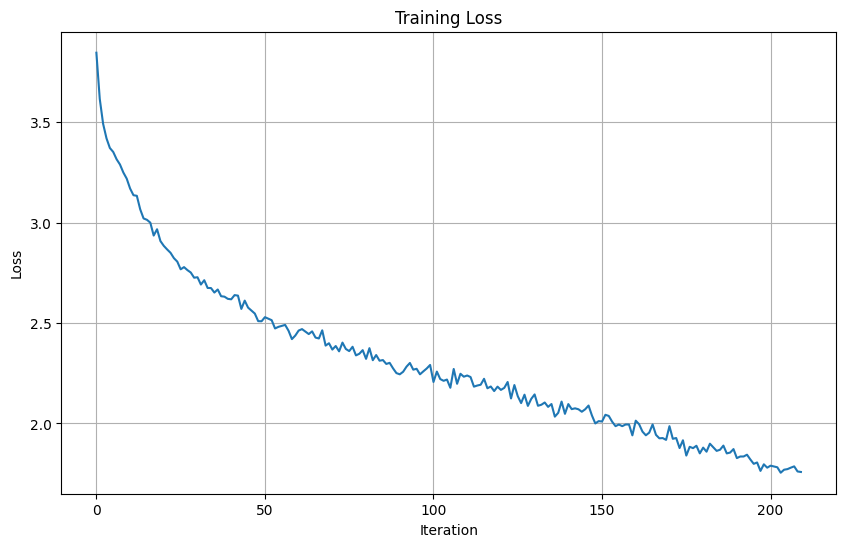

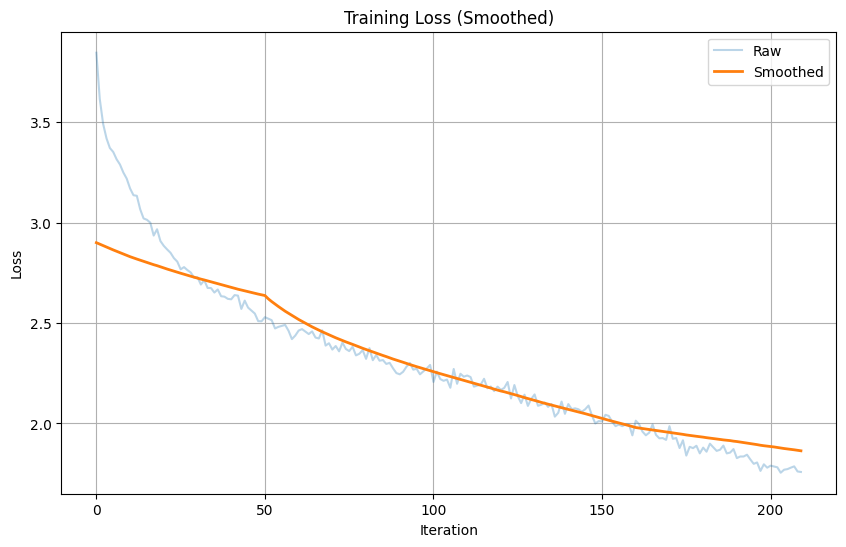

In [10]:
# 可视化训练loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# 绘制平滑后的loss（移动平均）
window_size = 100
if len(train_losses) > window_size:
    smoothed_losses = []
    for i in range(len(train_losses)):
        start = max(0, i - window_size // 2)
        end = min(len(train_losses), i + window_size // 2)
        smoothed_losses.append(np.mean(train_losses[start:end]))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, alpha=0.3, label='Raw')
    plt.plot(smoothed_losses, label='Smoothed', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss (Smoothed)')
    plt.legend()
    plt.grid(True)
    plt.show()

## 4. 推理/生成

In [11]:
@torch.no_grad()
def generate(model, prompt, max_new_tokens=100, temperature=1.0, top_k=None):
    """
    自回归生成文本
    
    参数:
    - model: 训练好的模型
    - prompt: 输入文本（字符串）
    - max_new_tokens: 最大生成token数
    - temperature: 采样温度（越高越随机）
    - top_k: top-k采样（只从概率最高的k个token中采样，None表示不使用）
    
    返回: 生成的文本
    """
    model.eval()
    
    # 编码prompt
    tokens = encode(prompt)
    tokens = torch.tensor([tokens], dtype=torch.long).to(device)
    
    # 生成新tokens
    for _ in range(max_new_tokens):
        # 如果序列太长，截断到max_seq_len
        if tokens.size(1) >= model.max_seq_len:
            tokens = tokens[:, -model.max_seq_len+1:]
        
        # 前向传播
        logits, _ = model(tokens)
        
        # 获取最后一个位置的logits
        logits = logits[0, -1, :] / temperature  # (vocab_size,)
        
        # Top-k采样
        if top_k is not None:
            top_k_logits, top_k_indices = torch.topk(logits, top_k)
            logits = torch.full_like(logits, float('-inf'))
            logits[top_k_indices] = top_k_logits
        
        # Softmax和采样
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        
        # 添加到序列
        tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)
        
        # 如果生成了结束符（可选，这里我们继续生成）
        # 可以根据需要添加停止条件
    
    # 解码并返回
    generated_text = decode(tokens[0].tolist())
    return generated_text

# 测试生成
model.eval()
prompt = "The quick brown"
generated = generate(model, prompt, max_new_tokens=50, temperature=0.8, top_k=10)
print(f"Prompt: {prompt}")
print(f"Generated: {generated}")
print(f"\n完整文本:\n{generated}")

Prompt: The quick brown
Generated: he quick brown eus.
The withe morend it in lel a vera sel mormpn

完整文本:
he quick brown eus.
The withe morend it in lel a vera sel mormpn


In [12]:
# 尝试不同的prompt和采样策略
test_prompts = [
    "Machine learning",
    "Deep learning",
    "Transformers",
    "Attention",
]

print("=" * 60)
for prompt in test_prompts:
    generated = generate(model, prompt, max_new_tokens=40, temperature=0.7, top_k=10)
    print(f"Prompt: '{prompt}'")
    print(f"Generated: {generated}")
    print("-" * 60)

Prompt: 'Machine learning'
Generated: Machine learning setroformatis tin diond thep suce centh
------------------------------------------------------------
Prompt: 'Deep learning'
Generated: Deep learning seforurnes wormarmaties rs rsutathe lat
------------------------------------------------------------
Prompt: 'Transformers'
Generated: Transformers routate res rentrathinataph ge groubute
------------------------------------------------------------
Prompt: 'Attention'
Generated: Attention ins he vellleay.
Sellig mos ayel nguse 
------------------------------------------------------------


## 5. 测试和评估

In [13]:
# 评估模型在训练数据上的困惑度（perplexity）
@torch.no_grad()
def evaluate_perplexity(model, dataloader):
    """计算困惑度"""
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        _, loss = model(x, y)
        total_loss += loss.item() * x.size(0) * x.size(1)
        total_tokens += x.size(0) * x.size(1)
    
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return perplexity, avg_loss

# 计算困惑度
perplexity, avg_loss = evaluate_perplexity(model, dataloader)
print(f"平均Loss: {avg_loss:.4f}")
print(f"困惑度 (Perplexity): {perplexity:.2f}")

平均Loss: 1.5678
困惑度 (Perplexity): 4.80


In [14]:
# 测试模型学习到的模式
print("测试模型学习能力:")
print("=" * 60)

# 测试1: 续写
prompt1 = "The transformer"
result1 = generate(model, prompt1, max_new_tokens=30, temperature=0.6)
print(f"测试1 - 续写:")
print(f"输入: {prompt1}")
print(f"输出: {result1}")
print()

# 测试2: 不同温度的影响
prompt2 = "Language models"
print(f"测试2 - 不同温度采样 (输入: '{prompt2}'):")
for temp in [0.3, 0.7, 1.0, 1.5]:
    result = generate(model, prompt2, max_new_tokens=25, temperature=temp)
    print(f"  Temperature {temp}: {result[:50]}...")
print()

# 测试3: 检查模型是否记住了训练数据中的模式
print("测试3 - 检查学习到的模式:")
test_patterns = [
    ("Machine", "learning"),
    ("Deep", "learning"),
    ("Attention", "mechanisms"),
]

for pattern_start, pattern_end in test_patterns:
    generated = generate(model, pattern_start, max_new_tokens=20, temperature=0.5)
    if pattern_end.lower() in generated.lower():
        print(f"  ✓ '{pattern_start}' -> 包含 '{pattern_end}'")
    else:
        print(f"  ✗ '{pattern_start}' -> 未包含 '{pattern_end}'")

测试模型学习能力:
测试1 - 续写:
输入: The transformer
输出: The transformerar te redulatedul pradintenten

测试2 - 不同温度采样 (输入: 'Language models'):
  Temperature 0.3: Language models the comoderel tos the to...
  Temperature 0.7: Language models the neare the de the tre...
  Temperature 1.0: Language models tod trmaterahr ghacten c...
  Temperature 1.5: Language models agveod noroaBaubs tej.
"...

测试3 - 检查学习到的模式:
  ✗ 'Machine' -> 未包含 'learning'
  ✗ 'Deep' -> 未包含 'learning'
  ✗ 'Attention' -> 未包含 'mechanisms'


### 模型总结

我们成功实现了一个极小的Transformer语言模型，包含：

1. **模型架构**:
   - 3层Transformer blocks
   - 128维隐藏状态
   - 4个注意力头
   - Pre-norm架构
   - 可学习的位置编码

2. **训练**:
   - 使用AdamW优化器
   - 交叉熵损失
   - 梯度裁剪防止梯度爆炸

3. **推理**:
   - 自回归生成
   - 支持temperature采样
   - 支持top-k采样

4. **特点**:
   - 字符级tokenization
   - Causal mask确保自回归性质
   - 完整的训练和推理流程

模型虽然很小，但已经能够学习文本中的基本模式并生成连贯的文本。